In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import os,errno
import sys
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
import datetime as dt
from scipy.ndimage.measurements import label
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
%matplotlib inline

dir2='/thorncroftlab_rit/ahenny/rain/'
dir1='/thorncroftlab_rit/ahenny/rain/US/ghcnd_all/'
dir='/thorncroftlab_rit/ahenny/rain/DISSERTATION_SCRIPTS_RESULTS/'
#determines sensitivity of precipitation to AR closeness

In [ ]:
if 1==1:#part 2: read the obs at eligible stations into a better format
    yr_start=1979
    yr_end=2019
    tuples=[]
    years=[]
    months=[]
    days1=[]
    lats1=[]
    lons1=[]
    elevs1=[]
    observations=[]
    dates=[]
    station_names_list=[]
    stations_list=[]
    dp=xr.open_dataset(dir+'station_numbers_95.nc')
    stations=dp.stations.values.tolist()
    lats=dp.lats.values.tolist()
    lons=dp.lons.values.tolist()
    elevs=dp.elevs.values.tolist()
    station_names=dp.station_names.values.tolist()
    points=zip(lons,lats)
    for i in range(len(stations)):
        print(str(i+1)+'/'+str(len(stations)))
        lat=lats[i]
        lon=lons[i]
        elev=elevs[i]
        station_name=station_names[i]
        station=stations[i]
        filename=stations[i]
        ds1=pd.read_csv(filename,header=None)
        nancount=0
        qcount=0
        yescount=0
        for row1 in ds1.iterrows():
            row_neg_space=row1[1][0].replace('-',' -')
            row_basic=row1[1][0]
            a=row_neg_space.split()
            code=a[0][-4:]
            if code=='PRCP':
                year=int(a[0][11:15])
                if yr_start<=year<=yr_end:
                    month=int(a[0][15:17])
                    if month in [1,3,5,7,8,10,12]:
                        days=31
                    if month in [4,6,9,11]:
                        days=30
                    if month==2 and year%4==0:
                        days=29
                    if month==2 and year%4!=0:
                        days=28

                    for i in range(days):
                        #print(row_basic)
                        mflag=row_basic[26+8*i]
                        qflag=row_basic[27+8*i]
                        sflag=row_basic[28+8*i]
                        obs=float(row_basic[21+8*i:26+8*i])
                    
                        if obs==-9999.0:
                            pass
                        elif qflag!=' ':
                            pass
                        else:
                            years.append(year)
                            months.append(month)
                            days1.append(i)
                            observations.append(obs/10.)#convert from tenths of mm to mm
                            lats1.append(lat)
                            lons1.append(lon)
                            elevs1.append(elev)
                            date=dt.datetime(year,month,i+1,6)
                            dates.append(date)
                            station_names_list.append(station_name)
                            stations_list.append(station)
    

In [3]:
#load AR data
dsa=xr.open_dataset(dir+'neusa_ar_points_test_var95const_ALL_1979.nc')
dsb=xr.open_dataset(dir+'neusa_ar_points_test_var95const_ALL_1980_1989.nc')
dsc=xr.open_dataset(dir+'neusa_ar_points_test_var95const_ALL_1990_1999.nc')
dsd=xr.open_dataset(dir+'neusa_ar_points_test_var95const_ALL_2000_2009.nc')
dse=xr.open_dataset(dir+'neusa_ar_points_test_var95const_ALL_2010_2019.nc')
ar1=dsa.ar
ar2=dsb.ar
ar3=dsc.ar
ar4=dsd.ar
ar5=dse.ar
ar=xr.concat([ar1,ar2,ar3,ar4,ar5],dim='time')

In [ ]:
percentile=95
lats=lats1
lons=lons1
obs=observations
zipped=list(zip(dates,lats,lons,obs,stations_list))
zipped_stations=list(zip(stations,lats,lons))
threshold_dict={}
for i in range(len(stations)):#make dictionary of thresholds
    print(str(i+1)+'/'+str(len(stations)))
    select_station=[x for x in zipped if x[-1]==stations[i]]
    station_obs=[x[-2] for x in select_station]
    measurable=[x for x in station_obs if x>=0.1]#0.1mm = measurable
    threshold=np.percentile(measurable,percentile,interpolation='linear')
    threshold_dict[stations[i]]=threshold
for i in range(yr_end-yr_start+1):#define all fall dates
    print(i)
    year=yr_start+i
    starting_date=dt.datetime(year,9,1,6)
    date_range=[starting_date+dt.timedelta(x) for x in range(91)]
    if i==0:
        all_dates=date_range
    else:
        all_dates=all_dates+date_range

In [5]:
ar['longitude']=ar.longitude.values-360.

In [6]:
ar=ar[:,0::2,0::2]#using 0.5-degree resolution here to save time; can increase if necessary.

In [ ]:
daily_extreme_totals=[]

lats_2d=xr.zeros_like(ar[0,:,:])
lons_2d=xr.zeros_like(ar[0,:,:])
for j in range(lats_2d.longitude.size):
    lats_2d[:,j]=lats_2d.latitude.values
for i in range(lons_2d.latitude.size):
    lons_2d[i,:]=lons_2d.longitude.values

distance_list=[]
obs_list=[]
for i in range(len(all_dates)):#now find extreme sums for each day
    print(i)
    starting_date=all_dates[i]
    print(starting_date)
    date_range=[starting_date+dt.timedelta(hours=6*x) for x in range(4)]
    select_day=[x for x in zipped if x[0]==starting_date]
    select_ar=ar.sel(time=date_range)
    select_ar=select_ar.max(dim='time',skipna=True)
    if select_ar.max().values>0:#get coords of AR in list form
    
        lats_2d_select=lats_2d.where(select_ar==1)
        lons_2d_select=lons_2d.where(select_ar==1)

        ar_flattened=select_ar.values.flatten().tolist()
        lats_flattened=lats_2d_select.values.flatten().tolist()
        lons_flattened=lons_2d_select.values.flatten().tolist()
        zipped_flat=list(zip(ar_flattened,lats_flattened,lons_flattened))
        select_flat=[x for x in zipped_flat if x[1]>0]
        coords_ar=[(x[2],x[1]) for x in select_flat]
        
        for j in range(len(select_day)):#choose lat and lon of precip observation
            select_lat=select_day[j][1]
            select_lon=select_day[j][2]
            select_obs=select_day[j][3]
            
            proceed='no'
            select_zone=[x for x in coords_ar if abs(x[1]-select_lat)<=5 and abs(x[0]-select_lon)<=7]#accurate to 550 km this way
            if len(select_zone)>0:#check that there is AR broadly within vicinity before doing specific distances
                proceed='yes'
            
            if proceed=='yes':
                min_distance=5000.
                for k in range(len(coords_ar)):#test all AR points and find min distance to station obs
                    lat_ar=coords_ar[k][1]
                    lon_ar=coords_ar[k][0]
                    distance=geopy.distance.distance((lat_ar,lon_ar),(select_lat,select_lon)).km
                    if distance<min_distance:
                        min_distance=distance
                distance_list.append(min_distance)
                obs_list.append(select_obs)

In [ ]:
print(len(distance_list))
print(len(obs_list))

In [ ]:
#get probability of different intensities as a function of distance
zipped_obs=list(zip(distance_list,obs_list))
prob_50_list=[]
prob_measurable_list=[]
mean_list=[]
for i in range(len(bins)-1):
    print(i)
    obs_select=[x[1] for x in zipped_obs if bins[i]<=x[0]<bins[i+1]]
    mean_obs_select=float(sum(obs_select))/float(len(obs_select))
    mean_list.append(mean_obs_select)
    
    obs_50=[x[1] for x in zipped_obs if bins[i]<=x[0]<bins[i+1] and x[1]>=50]
    obs_1=[x[1] for x in zipped_obs if bins[i]<=x[0]<bins[i+1] and x[1]>=1]
    percent_50=float(len(obs_50))/float(len(obs_select))
    
    percent_1=float(len(obs_1))/float(len(obs_select))
    prob_50_list.append(percent_50)
    prob_measurable_list.append(percent_1)

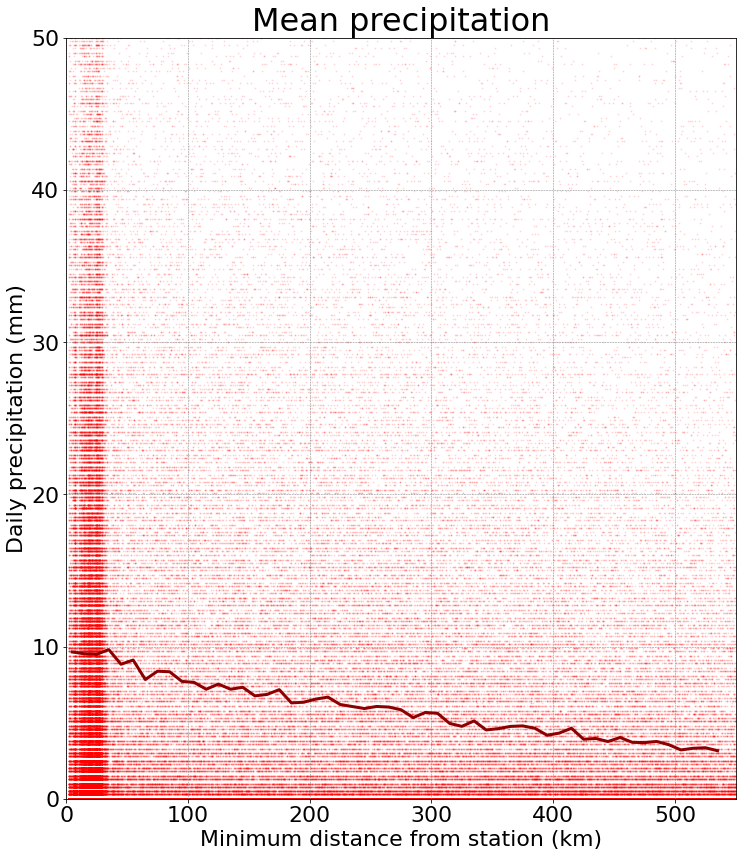

In [39]:
fig=plt.figure(figsize=(12,14))
ax=plt.subplot(1,1,1)
#plot of min distance (from station) vs daily rainfall
ax.scatter(distance_list,obs_list,s=1,c='r',alpha=0.1)#,label='IBTrACS TCs')
ax.plot([x+5 for x in bins[:-1]],mean_list,color='darkred',linewidth=3.0)#,label='IBTrACS TCs')
ax.tick_params(labelsize=22)
ax.grid(True,linestyle='--',linewidth=0.5,color='grey')
ax.set_xlabel('Minimum distance from station (km)',fontsize=22)
ax.set_ylabel('Daily precipitation (mm)',fontsize=22)
ax.set_xlim(0,550)
ax.set_ylim(0,50)
ax.set_title('Mean precipitation',fontsize=32)
plt.show()

In [40]:
fig.savefig(dir+'neusa_ar_proximity_test_1.png')

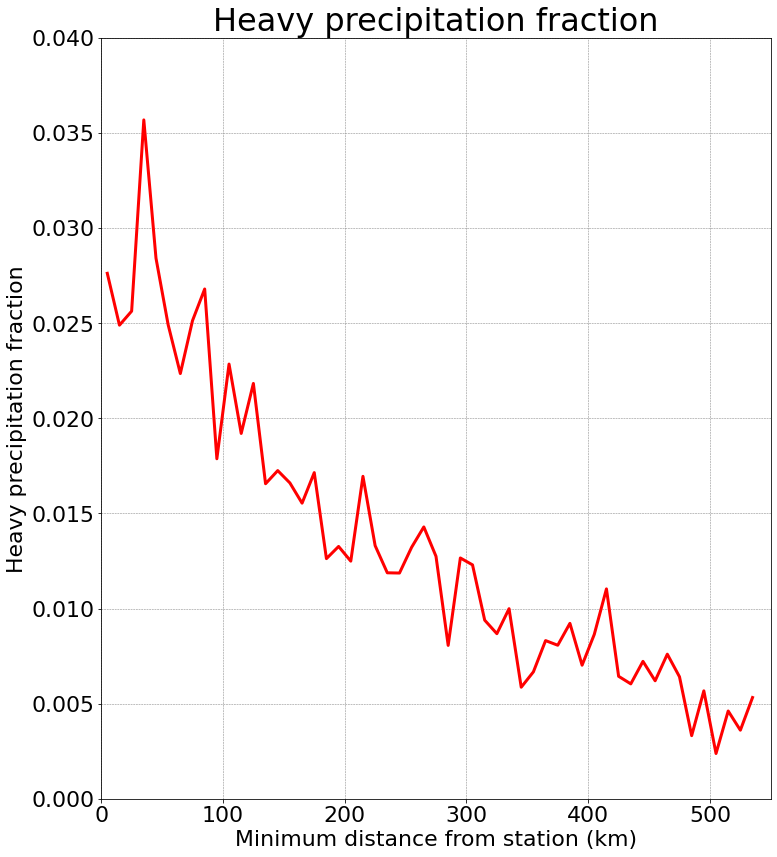

In [53]:
fig=plt.figure(figsize=(12,14))
ax=plt.subplot(1,1,1)
#plot of min distance (from station) vs probability of >=50 mm/day precipitation
ax.plot([x+5 for x in bins[:-1]],prob_50_list,color='r',linewidth=3.0)#,label='IBTrACS TCs')
ax.tick_params(labelsize=22)
ax.grid(True,linestyle='--',linewidth=0.5,color='grey')
ax.set_xlabel('Minimum distance from station (km)',fontsize=22)
ax.set_ylabel('Heavy precipitation fraction',fontsize=22)
ax.set_xlim(0,550)
ax.set_ylim(0,0.04)
ax.set_title('Heavy precipitation fraction',fontsize=32)
plt.show()

In [54]:
fig.savefig(dir+'neusa_ar_proximity_test_2.png')

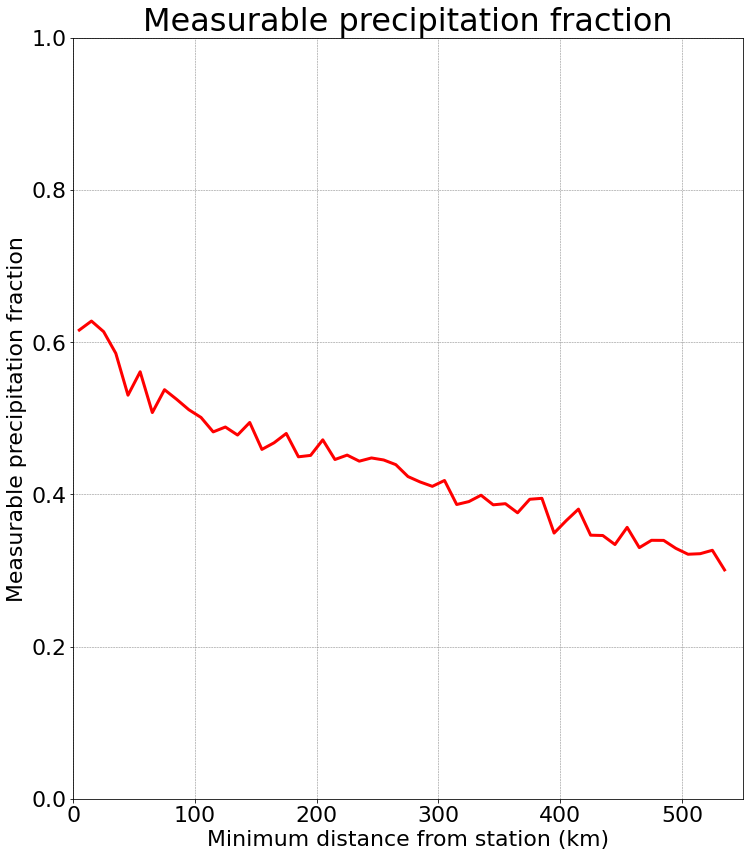

In [44]:
fig=plt.figure(figsize=(12,14))
ax=plt.subplot(1,1,1)
#plot of min distance (from station) vs probability of >=50 mm/day precipitation
ax.plot([x+5 for x in bins[:-1]],prob_measurable_list,color='r',linewidth=3.0)#,label='IBTrACS TCs')
ax.tick_params(labelsize=22)
ax.grid(True,linestyle='--',linewidth=0.5,color='grey')
ax.set_xlabel('Minimum distance from station (km)',fontsize=22)
ax.set_ylabel('Measurable precipitation fraction',fontsize=22)
ax.set_xlim(0,550)
ax.set_ylim(0,1)
ax.set_title('Measurable precipitation fraction',fontsize=32)
plt.show()

In [45]:
fig.savefig(dir+'neusa_ar_proximity_test_3.png')